In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
df = pd.read_pickle('index300.pkl ')

# 回测模块导入

In [3]:
from backtest.dataframe import TradeSession, PMPandas
from backtest.base_api import event_generator

# 一个例子

## 极简回测实现

### 策略逻辑

1. 每隔5个交易日，开盘的时候买入5个价格最低的股票（扣除即将退市）  
    a. 如果开盘买入不成功则取消订单
2. 持有至第4个交易日收盘， 以市价单卖出  
    b. 如果收盘没有交易成功，直到交易成功为止  

In [4]:
class PM1(PMPandas):
    """基金经理（策略）的具体实现"""
    
    def init(self):        
        # 获取市场数据， 粗略计算距离退市的时间
        data = self.get_mkt_data()
        data['ndelist'] = data.groupby('code', group_keys=False)['tradeDate'].apply(
            lambda x: pd.Series(range(len(x), 0, -1), index=x.index))
#         self.pb = pd.read_csv('xxx')
        # 初始化一个计数的变量
        self.open_count = 0 
        print('-'*10 + '初始化工作完成' + '-'*10)
        
        
    def after_open(self):
        if  self.open_count % 5 == 0:   
            self.cancel_orders(self.active_orders.query("targetVol > 0"))
            data = self.get_mkt_frame()
            data = data.sort_values('settlePrice').head(5).query("ndelist > 30")
            data['ratio_relative'] = data['settlePrice'] # 以价格为成交比例 
            data['code'] = data.index
            self.send_orders(
                data[['code', 'ratio_relative']].copy(),
                ratio_to_netasset=0.5,  # 二分之一的仓位去交易
                order_type='ratio_market',
                order_seq=1)  # 交易优先级靠后， 保证有足够的资金释放
        self.open_count += 1 
        
    def after_close(self):
        if  (self.open_count+1) % 5 == 0:
#             self.position_sell = self.position.query("code in {}")
            self.sell_position(self.position, 
                               order_seq=0) # 交易优先级靠前， 保证有足够的资金释放
            
#     def after_evnt(self):
#         pass
            
    def __str__(self):
        return("精简版本的策略")

### 策略运行

In [6]:
ts = TradeSession(PM1, start_datetime='2021-01-01', end_datetime='2021-03-01', markets='stock_daily')
obs = ts.run()

----------初始化工作完成----------


## 回测结果

### 结果

#### 组合现状

In [7]:
obs.position

,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol
0,58,60,stock_daily,000662.SZ,2021-02-26 09:30:00,2.819443,2.537499,3.090371e+06,-0.0
1,65,61,stock_daily,000585.SZ,2021-03-01 15:00:00,2.186808,2.186808,3.585720e+06,-0.0
2,66,62,stock_daily,000820.SZ,2021-03-01 15:00:00,2.771862,2.771862,3.503761e+06,-0.0
3,67,63,stock_daily,000809.SZ,2021-03-01 15:00:00,5.293855,5.293855,3.465468e+06,-0.0
4,68,64,stock_daily,000882.SZ,2021-03-01 15:00:00,5.329569,5.329569,3.445039e+06,-0.0


In [8]:
obs.balance

{'netAsset': 108546093.89819728, 'cash': 46444798.81221024, 'frozenCash': 0}

In [9]:
obs.active_orders

,orderID,secuType,code,orderTime,orderType,direction,targetPrice,targetVol,filledVol,offsetID,status,orderSeq


In [10]:
obs.active_order_params

{}

#### 交易记录

In [11]:
obs.trade_records.tail()

,tradeID,orderID,secuType,code,transTime,direction,transPrice,transVol,offsetID,transCost
60,60,58,stock_daily,000662.SZ,2021-02-26 09:30:00,long,2.819443,3.090371e+06,-1,4356.562782
61,61,65,stock_daily,000585.SZ,2021-03-01 15:00:00,long,2.186808,3.585720e+06,-1,3920.640577
62,62,66,stock_daily,000820.SZ,2021-03-01 15:00:00,long,2.771862,3.503761e+06,-1,4855.970447
63,63,67,stock_daily,000809.SZ,2021-03-01 15:00:00,long,5.293855,3.465468e+06,-1,9172.843917
64,64,68,stock_daily,000882.SZ,2021-03-01 15:00:00,long,5.329569,3.445039e+06,-1,9180.286098


#### balance记录

In [12]:
obs.balance_records.tail()

,recordTime,netAsset,cash,frozenCash,date
31,2021-02-23 20:00:00,1.073770e+08,5.325937e+07,9.584438e+06,2021-02-23
32,2021-02-24 20:00:00,1.079282e+08,5.325937e+07,9.584438e+06,2021-02-24
33,2021-02-25 20:00:00,1.095299e+08,5.325937e+07,9.584438e+06,2021-02-25
34,2021-02-26 20:00:00,1.094445e+08,1.007314e+08,0.000000e+00,2021-02-26
35,2021-03-01 20:00:00,1.085461e+08,4.644480e+07,0.000000e+00,2021-03-01


#### 持仓记录

In [13]:
obs.position_records

,recordTime,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol,date,mktv
0,2021-01-04 20:00:00,0,0,stock_daily,000585.SZ,2021-01-04 15:00:00,2.161231,2.161231,2.885761e+06,-0.0,2021-01-04,6.236797e+06
1,2021-01-04 20:00:00,1,1,stock_daily,000820.SZ,2021-01-04 15:00:00,2.367632,2.367632,2.777867e+06,-0.0,2021-01-04,6.576966e+06
2,2021-01-04 20:00:00,2,2,stock_daily,000980.SZ,2021-01-04 15:00:00,2.830359,2.830359,2.877375e+06,-0.0,2021-01-04,8.144004e+06
3,2021-01-04 20:00:00,3,3,stock_daily,000662.SZ,2021-01-04 15:00:00,4.454720,4.454720,2.883355e+06,-0.0,2021-01-04,1.284454e+07
4,2021-01-04 20:00:00,4,4,stock_daily,000882.SZ,2021-01-04 15:00:00,5.537988,5.537988,2.920321e+06,-0.0,2021-01-04,1.617271e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
146,2021-03-01 20:00:00,58,60,stock_daily,000662.SZ,2021-02-26 09:30:00,2.819443,2.537499,3.090371e+06,-0.0,2021-03-01,7.841813e+06
147,2021-03-01 20:00:00,65,61,stock_daily,000585.SZ,2021-03-01 15:00:00,2.186808,2.186808,3.585720e+06,-0.0,2021-03-01,7.841281e+06
148,2021-03-01 20:00:00,66,62,stock_daily,000820.SZ,2021-03-01 15:00:00,2.771862,2.771862,3.503761e+06,-0.0,2021-03-01,9.711941e+06
149,2021-03-01 20:00:00,67,63,stock_daily,000809.SZ,2021-03-01 15:00:00,5.293855,5.293855,3.465468e+06,-0.0,2021-03-01,1.834569e+07


### 检查

持仓资产+现金等于基金净值

In [14]:
obs.check_position_net()

,netAsset,cash,position_asset,netAsset_cal
recordTime,,,,
2021-01-04 20:00:00,9.997501e+07,5.000000e+07,4.997501e+07,9.997501e+07
2021-01-05 20:00:00,9.903659e+07,5.000000e+07,4.903659e+07,9.903659e+07
2021-01-06 20:00:00,9.783459e+07,5.000000e+07,4.783459e+07,9.783459e+07
2021-01-07 20:00:00,9.638446e+07,5.000000e+07,4.638446e+07,9.638446e+07
2021-01-08 20:00:00,9.564847e+07,9.564847e+07,NaN,9.564847e+07
2021-01-11 20:00:00,9.562457e+07,4.782424e+07,4.780034e+07,9.562457e+07
2021-01-12 20:00:00,9.518475e+07,4.782424e+07,4.736052e+07,9.518475e+07
2021-01-13 20:00:00,9.490429e+07,4.782424e+07,4.708005e+07,9.490429e+07
2021-01-14 20:00:00,9.588625e+07,4.782424e+07,4.806201e+07,9.588625e+07


期初期末持仓价值变动+期间的交易的费用=期初期末净资产的变动

In [15]:
obs.check_trade_net()

{'nav_end': 108546093.89819728,
 'nav_start': 99975012.49375312,
 'trade_amount': 2928910.527811222,
 'trade_cost': 626290.6599785528,
 'pv_end': 62101295.085986994,
 'pv_start': 49975012.49375312,
 'nav_end_cal': 108546093.89819722}

期末持仓等于期初持仓+期间的交易

In [16]:
obs.check_trade_position()

volume_start  volume_trade    volume_end  volume_net
secuType    code                                                           
stock_daily 000585.SZ  2.885761e+06  6.999589e+05  3.585720e+06         0.0
            000662.SZ  2.883355e+06  2.070160e+05  3.090371e+06         0.0
            000820.SZ  2.777867e+06  7.258943e+05  3.503761e+06         0.0
            000882.SZ  2.920321e+06  5.247173e+05  3.445039e+06         0.0
            000980.SZ  2.877375e+06 -2.877375e+06           NaN         0.0
            000613.SZ           NaN  0.000000e+00           NaN         0.0
            000809.SZ           NaN  3.465468e+06  3.465468e+06         0.0

### 分析

In [17]:
obs.pnl_analyse(freq='week', benchmark=df,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,0.134844,1.275543,0.102642,0.008209,12.427060,4.573011
benchmark,-0.042332,-0.245088,0.279200,0.093827,-0.877824,NaN


In [18]:
obs.get_pnl_net(benchmark=df, freq='week')

,netAsset,benchmark
2021-01-10,9.564847e+07,5495.4306
2021-01-17,9.603676e+07,5458.0812
2021-01-24,9.856347e+07,5569.7760
2021-01-31,1.025114e+08,5351.9646
2021-02-07,1.035563e+08,5483.4140
2021-02-14,1.045816e+08,5807.7191
2021-02-21,1.065275e+08,5778.8420
2021-02-28,1.094445e+08,5336.7609
2021-03-07,1.085461e+08,5262.7958


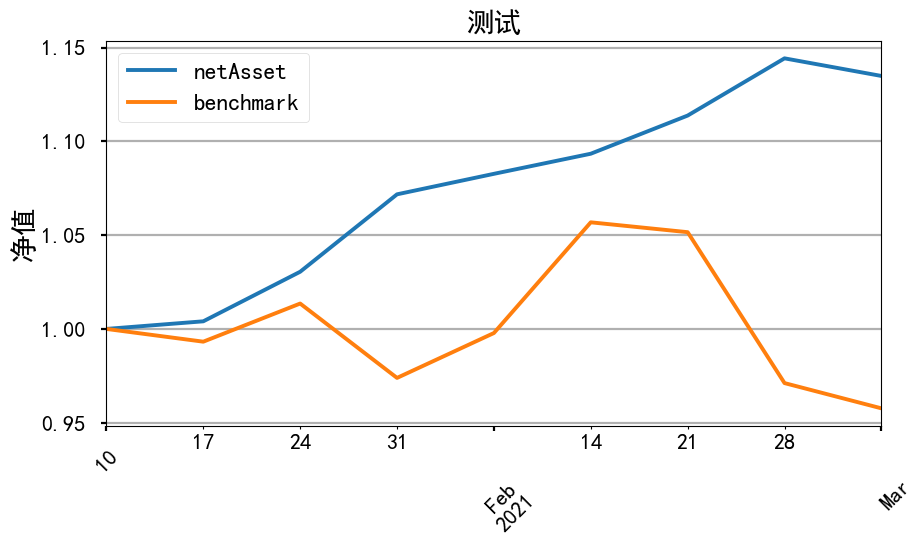

In [19]:
obs.pnl_plot(title='测试',benchmark=df, freq='week')

# 策略端实现逻辑

## 策略模板

回测的过程实际上就是在“事件”发生之后， 结合“市场数据”与“当前组合状态”而做出“决策”的过程  
1. 事件
    1. 行情触发类事件，如“open”， “close”
    2. 记录类事件“record”
    3. 自定义事件（见下例）
2. 市场数据
    1. 市场数据 self.get_mkt_data, self.get_mkt_obj, self.get_mkt_frame
    2. 其它外部数据， 通过self.init实现数据或信号的传入
3. 组合状态
    1. 资产数据 self.balance
    2. 持仓数据 self.position
    3. 活跃的订单数据  self.active_orders
4. 决策
    1. 买入 self.send_orders
    2. 取消订单 self.cancel_orders
    3. 平仓 self.sell_position

In [21]:
class PM2(PMPandas):
    """基金经理（策略）的具体实现"""
    
    def init(self):
        print('回测前基金经理开始做准备工作了：') 
        print('先把计算好的信号放进来（可以读取外部数据，可以用内部数据计算）：')
        self.signal = [0,1,2] 
        print(f'信号已经读进来了，信号是;{self.signal}')
        print('其它的准备工作：')
        # 获取市场数据， 粗略计算距离退市的时间
        data = self.get_mkt_data()
        data['ndelist'] = data.groupby('code', group_keys=False)['tradeDate'].apply(
            lambda x: pd.Series(range(len(x), 0, -1), index=x.index))
        
        # 初始化一个计数的变量
        self.n_any = self.open_count = 0 
        print('其它的准备工作已经完成')
        print('-'*10 + '初始化工作完成' + '-'*10)
        
        
    def after_open(self):
        if  self.open_count % 5 == 0:
            self.cancel_orders(self.active_orders.query("targetVol > 0"))
            print(f'{self.observer.time}开盘了，且self.open_count是5的整数倍，执行买入操作')         
            data = self.get_mkt_frame()
            data = data.sort_values('settlePrice').head(5).query("ndelist > 30")
            data['ratio_relative'] = data['settlePrice'] # 以价格为成交比例
            data['code'] = data.index
            self.send_orders(
                data[['code', 'ratio_relative']].copy(),
                ratio_to_netasset=0.5,  # 二分之一的现金去交易
                order_type='ratio_market',
                order_seq=1)  # 交易优先级靠后， 保证有足够的资金释放
        self.open_count += 1 
        
    def after_close(self):
        if  (self.open_count+1) % 5 == 0:
            print(f'{self.observer.time}收盘了，触发卖出条件，执行平仓操作') 
            self.sell_position(self.position)
    
    def after_any(self):
        self.n_any += 1
        print(f'{self.observer.time}any类型的事件第{self.n_any}次被触发了')
        if self.n_any == 1:
            print('---'*15)
            print("当前基金经理可以获得的外部数据和内部数据包含：")
            print(f"当前时间:{self.observer.time}")
            print(f"当前持仓:{self.position}")
            print(f"当前权益:{self.balance}")
            print(f"当前活跃订单:{self.active_orders}")
            print(f"当前市场行情:{self.get_mkt_data().tail()}")
            print(f"外部输入的信号:{self.signal}")
            print('---'*15)
            
    def __str__(self):
        return("打印注释版本的策略")

## 增加any类事件

### 当前事件类型

In [22]:
pd.DataFrame(ts.events)['event_type'].value_counts()

event_type
EventType.OPEN      2685
EventType.CLOSE     2685
EventType.RECORD      37
Name: count, dtype: int64

### 添加any类事件类型

In [23]:
t_series = pd.date_range('2021-01-01', '2021-03-01', freq='w')
events = event_generator(t_series.to_pydatetime(), event_type='any')
ts.add_events(events)

In [24]:
pd.DataFrame(ts.events)['event_type'].value_counts()

event_type
EventType.OPEN      2685
EventType.CLOSE     2685
EventType.RECORD      37
any                    9
Name: count, dtype: int64

### 更改ts的PM类，重新回测

In [25]:
ts.PortfolioManager = PM2
obs = ts.run()

回测前基金经理开始做准备工作了：
先把计算好的信号放进来（可以读取外部数据，可以用内部数据计算）：
信号已经读进来了，信号是;[0, 1, 2]
其它的准备工作：
其它的准备工作已经完成
----------初始化工作完成----------
2021-01-03 00:00:00any类型的事件第1次被触发了
---------------------------------------------
当前基金经理可以获得的外部数据和内部数据包含：
当前时间:2021-01-03 00:00:00
当前持仓:Empty DataFrame
Columns: [orderID, tradeID, secuType, code, transTime, transPrice, settlePrice, volume, frozenVol]
Index: []
当前权益:{'netAsset': 100000000.0, 'cash': 100000000.0, 'frozenCash': 0.0}
当前活跃订单:Empty DataFrame
Columns: [orderID, secuType, code, orderTime, orderType, direction, targetPrice, targetVol, filledVol, offsetID, status, orderSeq]
Index: []
当前市场行情:              code  tradeDate     openAdj     highAdj     lowAdj    closeAdj   
2993188  000999.SZ 2023-01-12   99.439538  101.938231  97.660806   98.846627  \
2993189  000999.SZ 2023-01-13   99.439538  101.535899  97.851385  101.366496   
2993190  000999.SZ 2023-01-16  101.641776  102.869947  99.524239  100.286552   
2993191  000999.SZ 2023-01-17  100.371254  101.366496  9

# 回测参数修改

## 可通过赋值修改的参数

In [26]:
print(ts.start_datetime)
print(ts.end_datetime)
print(ts.pm) # 策略的实例化
print(ts.cash)

2021-01-01 00:00:00
2021-03-02 00:00:00
打印注释版本的策略
100000000.0


In [27]:
ts.start_datetime = '2018-01-01'# 更改回测开始时间
ts.end_datetime = '2021-12-31' # 更改回测结束时间
ts.PortfolioManager = PM1  # 更改策略
ts.cash = 1e10 # 更改初始资金大小

In [28]:
print(ts.start_datetime)
print(ts.end_datetime)
print(ts.PortfolioManager)  # 策略已经变为PM1了
print(ts.cash)

2018-01-01 00:00:00
2022-01-01 00:00:00
<class '__main__.PM1'>
10000000000.0


## 市场的修改

In [29]:
ts.market_list[0].data['tradeDate'].min()

Timestamp('2012-01-04 00:00:00')

In [30]:
ts.reset_markets('stock_daily', mkt_startdate='2017-01-01') # 第一个值为模块名称， 第二个值为市场数读取时间
ts.market_list[0].data['tradeDate'].min()

Timestamp('2017-01-03 00:00:00')

## 记录频率修改

1. 记录类事件仅仅在ts初始化的时候初始化一次，后面修改回测时间区间的时候纪录类时间不会自动改变
2. 纪录类时间可以通过init_records重新按固定的设置重新生成
3. 纪录类时间可以通过reset_records替代当前的纪录类事件

In [31]:
print("目前纪录类事件还是初始化时候生成的")
pd.DataFrame(ts.events)['event_type'].value_counts()

目前纪录类事件还是初始化时候生成的


event_type
EventType.OPEN      1471
EventType.CLOSE     1471
EventType.RECORD      37
any                    9
Name: count, dtype: int64

In [32]:
print("重新初始化后为周频记录")
ts.init_records()
pd.DataFrame(ts.events)['event_type'].value_counts()

重新初始化后为周频记录


event_type
EventType.OPEN      1471
EventType.CLOSE     1471
EventType.RECORD     973
any                    9
Name: count, dtype: int64

In [33]:
t_series = pd.date_range(ts.start_datetime,ts.end_datetime)
events = event_generator(t_series.to_pydatetime(), event_type='record')
ts.reset_records(events)
print("替换为日频记录")
pd.DataFrame(ts.events)['event_type'].value_counts()

替换为日频记录


event_type
EventType.OPEN      1471
EventType.CLOSE     1471
EventType.RECORD    1462
any                    9
Name: count, dtype: int64

## 运行修改后的回测

In [34]:
obs = ts.run()

----------初始化工作完成----------


In [35]:
print(ts.pm)  # 策略已经变为PM1了

精简版本的策略


### 结果

#### 组合现状

In [36]:
obs.position

,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol
0,1860,1844,stock_daily,000585.SZ,2021-12-29 15:00:00,2.608823,2.621612,2.051892e+08,-0.0
1,1861,1845,stock_daily,000927.SZ,2021-12-29 15:00:00,5.638050,5.622168,2.050383e+08,-0.0
2,1862,1846,stock_daily,000882.SZ,2021-12-29 15:00:00,5.637086,5.696737,2.051090e+08,-0.0
3,1863,1847,stock_daily,000613.SZ,2021-12-29 15:00:00,5.519800,5.834400,2.104736e+08,-0.0
4,1864,1848,stock_daily,000687.SZ,2021-12-29 15:00:00,6.111182,6.111182,2.096559e+08,-0.0


In [37]:
obs.balance

{'netAsset': 10661568085.042217, 'cash': 5293197814.438456, 'frozenCash': 0}

In [38]:
obs.active_orders

,orderID,secuType,code,orderTime,orderType,direction,targetPrice,targetVol,filledVol,offsetID,status,orderSeq


In [39]:
obs.active_order_params

{}

#### 交易记录

In [40]:
obs.trade_records.tail()

,tradeID,orderID,secuType,code,transTime,direction,transPrice,transVol,offsetID,transCost
1844,1844,1860,stock_daily,000585.SZ,2021-12-29 15:00:00,long,2.608823,2.051892e+08,-1,267651.205239
1845,1845,1861,stock_daily,000927.SZ,2021-12-29 15:00:00,long,5.638050,2.050383e+08,-1,578008.067395
1846,1846,1862,stock_daily,000882.SZ,2021-12-29 15:00:00,long,5.637086,2.051090e+08,-1,578108.467203
1847,1847,1863,stock_daily,000613.SZ,2021-12-29 15:00:00,long,5.519800,2.104736e+08,-1,580886.001735
1848,1848,1864,stock_daily,000687.SZ,2021-12-29 15:00:00,long,6.111182,2.096559e+08,-1,640622.527513


#### balance记录

In [41]:
obs.balance_records.tail()

,recordTime,netAsset,cash,frozenCash,date
1457,2021-12-28,1.058617e+10,5.378084e+09,0.0,2021-12-28
1458,2021-12-29,1.058640e+10,1.058640e+10,0.0,2021-12-29
1459,2021-12-30,1.058375e+10,5.293198e+09,0.0,2021-12-30
1460,2021-12-31,1.063562e+10,5.293198e+09,0.0,2021-12-31
1461,2022-01-01,1.066157e+10,5.293198e+09,0.0,2022-01-01


#### 持仓记录

In [42]:
obs.position_records

,recordTime,orderID,tradeID,secuType,code,transTime,transPrice,settlePrice,volume,frozenVol,date,mktv
0,2018-01-03,0,0,stock_daily,000875.SZ,2018-01-02 15:00:00,5.489387,5.489387,1.408787e+08,-0.0,2018-01-03,7.733376e+08
1,2018-01-03,2,1,stock_daily,000927.SZ,2018-01-02 15:00:00,7.242114,7.242114,1.419708e+08,-0.0,2018-01-03,1.028169e+09
2,2018-01-03,3,2,stock_daily,000166.SZ,2018-01-02 15:00:00,7.521514,7.521514,1.417069e+08,-0.0,2018-01-03,1.065850e+09
3,2018-01-03,4,3,stock_daily,000931.SZ,2018-01-02 15:00:00,8.182565,8.182565,1.436168e+08,-0.0,2018-01-03,1.175154e+09
4,2018-01-04,0,0,stock_daily,000875.SZ,2018-01-02 15:00:00,5.489387,5.573839,1.408787e+08,-0.0,2018-01-04,7.852351e+08
...,...,...,...,...,...,...,...,...,...,...,...,...
5525,2022-01-01,1860,1844,stock_daily,000585.SZ,2021-12-29 15:00:00,2.608823,2.621612,2.051892e+08,-0.0,2022-01-01,5.379264e+08
5526,2022-01-01,1861,1845,stock_daily,000927.SZ,2021-12-29 15:00:00,5.638050,5.622168,2.050383e+08,-0.0,2022-01-01,1.152760e+09
5527,2022-01-01,1862,1846,stock_daily,000882.SZ,2021-12-29 15:00:00,5.637086,5.696737,2.051090e+08,-0.0,2022-01-01,1.168452e+09
5528,2022-01-01,1863,1847,stock_daily,000613.SZ,2021-12-29 15:00:00,5.519800,5.834400,2.104736e+08,-0.0,2022-01-01,1.227987e+09


### 检查

持仓资产+现金等于基金净值

In [43]:
obs.check_position_net()

,netAsset,cash,position_asset,netAsset_cal
recordTime,,,,
2018-01-01,1.000000e+10,1.000000e+10,NaN,1.000000e+10
2018-01-02,1.000000e+10,1.000000e+10,NaN,1.000000e+10
2018-01-03,9.997979e+09,5.955468e+09,4.042510e+09,9.997979e+09
2018-01-04,1.003740e+10,5.955468e+09,4.081931e+09,1.003740e+10
2018-01-05,1.002434e+10,5.955468e+09,4.068873e+09,1.002434e+10
...,...,...,...,...
2021-12-28,1.058617e+10,5.378084e+09,5.208083e+09,1.058617e+10
2021-12-29,1.058640e+10,1.058640e+10,NaN,1.058640e+10
2021-12-30,1.058375e+10,5.293198e+09,5.290553e+09,1.058375e+10


期初期末持仓价值变动+期间的交易的费用=期初期末净资产的变动

In [44]:
obs.check_trade_net()

{'nav_end': 10661568085.042217,
 'nav_start': 9997978744.789328,
 'trade_amount': -1085238653.2366724,
 'trade_cost': 1747509162.2432728,
 'pv_end': 5368370270.60375,
 'pv_start': 4042510421.344275,
 'nav_end_cal': 10661568085.042204}

期末持仓等于期初持仓+期间的交易

In [45]:
obs.check_trade_position()

volume_start  volume_trade    volume_end  volume_net
secuType    code                                                           
stock_daily 000166.SZ  1.417069e+08 -1.417069e+08           NaN         0.0
            000875.SZ  1.408787e+08 -1.408787e+08           NaN         0.0
            000927.SZ  1.419708e+08  6.306753e+07  2.050383e+08         0.0
            000931.SZ  1.436168e+08 -1.436168e+08           NaN         0.0
            000068.SZ           NaN  0.000000e+00           NaN         0.0
            000155.SZ           NaN  0.000000e+00           NaN         0.0
            000533.SZ           NaN  0.000000e+00           NaN         0.0
            000536.SZ           NaN  0.000000e+00           NaN         0.0
            000585.SZ           NaN  2.051892e+08  2.051892e+08         0.0
            000613.SZ           NaN  2.104736e+08  2.104736e+08         0.0
            000620.SZ           NaN  0.000000e+00           NaN         0.0
            000662.SZ           NaN  0.000000e+00           NaN         0.0
            000669.SZ           NaN  0.000000e+00           NaN         0.0
            000687.SZ           NaN  2.096559e+08  2.096559e+08         0.0
            000761.SZ           NaN  0.000000e+00           NaN         0.0
            000809.SZ           NaN  0.000000e+00           NaN         0.0
            000820.SZ           NaN  0.000000e+00           NaN         0.0
            000882.SZ           NaN  2.051090e+08  2.051090e+08         0.0
            000918.SZ           NaN  0.000000e+00           NaN         0.0
            000972.SZ           NaN  0.000000e+00           NaN         0.0
            000980.SZ           NaN  0.000000e+00           NaN         0.0
            000981.SZ           NaN  0.000000e+00           NaN         0.0
            000995.SZ           NaN  0.000000e+00           NaN         0.0

### 分析

In [46]:
obs.pnl_analyse(freq='day', benchmark=df,  chicol=True)

,总收益率,年化收益率,年化风险,最大回撤,夏普比率,信息比率
netAsset,0.063562,0.015590,0.116182,0.244836,0.134182,-0.135915
benchmark,0.208683,0.048728,0.204022,0.324620,0.238837,NaN


In [47]:
obs.get_pnl_net(benchmark=df, freq='day')

,netAsset,benchmark
2018-01-02,1.000000e+10,4087.4012
2018-01-03,9.997979e+09,4111.3925
2018-01-04,1.003740e+10,4128.8119
2018-01-05,1.002434e+10,4138.7505
2018-01-08,1.007038e+10,4160.1595
...,...,...
2021-12-27,1.055769e+10,4919.3238
2021-12-28,1.058617e+10,4955.9644
2021-12-29,1.058640e+10,4883.4804
2021-12-30,1.058375e+10,4921.5109


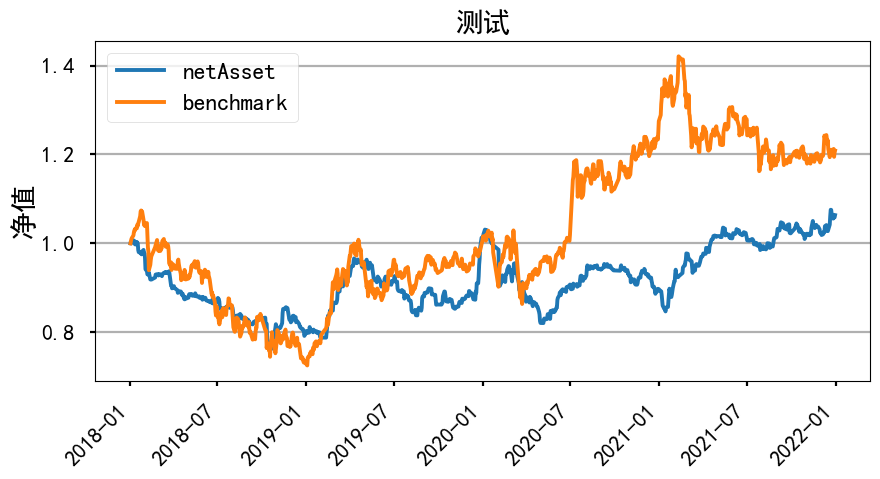

In [48]:
obs.pnl_plot(title='测试',benchmark=df, freq='day')

# 添加新市场和新的订单策略

1. 在dataframe框架下， 同一个市场类型（SecuType）的市场类和订单策略类要放在一个模块下（参考stock_daily)
2. 市场类型和策略订单类型要在constant脚本中的SecuType, OrderType下添加成员

## 新增市场要点

1. 类变量实现手续费率与证券类型
2. 初始化方法：
    1. start_data为参数， 确定数据读取的范围，如果有其它参数建议传入默认值
    1. 执行后， 实例需要有self.data, self.trigger_events属性
3. init方法必须实现，执行后市场状态会改变至t时刻之间
4. on_trigger方法必须实现，定义了遇到行情推动事件时市场状态如何改变 
5. settlement方法必须实现，输入持仓数据， 返回结算好的持仓数据与盈利值

## 新增订单策略要点

1. 类变量实现证券类型与订单类型
2. 实现send_orders方法
    1. 传入参数要包含order_seq参数， 确定订单执行的相对顺序
    2. 函数实现后要执行两行代码：
        1. self.observer.add_active_orders(order_data)  # 提交订单
        2. self.observer.cal_frozen()  # 计算冻结的资金和冻结的持仓
    3. 函数内部实现该类订单的生成的过程
2. 基于行情推动事件的交易逻辑（如 on_close）：
    1. 方法以‘on_’+ EventType.value的形式命名
    2. 方法的输入为属于该订单策略处理的订单数据
    3. 方法的输出为订单的三个去向
        1. 未完成交易并继续执行订单；
        2. 未完成交易并取消订单；
        3. 完成交易。
    4. 市场有几个行情推动事件， 订单策略就必须实现几个对应的方法，如果不准备调用该方法直接pass也可以


# 新的订单策略-VWAP

In [56]:
class PMVWAP(PMPandas):
    """基金经理（策略）的具体实现"""
    ratio_limit = 0.001

    def init(self):
        # 获取市场数据， 粗略计算距离退市的时间
        data = self.get_mkt_data()
        data['ndelist'] = data.groupby(
            'code', group_keys=False)['tradeDate'].apply(
                lambda x: pd.Series(range(len(x), 0, -1), index=x.index))

        # 初始化一个计数的变量
        self.open_count = 0

    def after_open(self):
        if self.open_count % 5 == 0:
            self.cancel_orders(self.active_orders.query("targetVol > 0"))
            data = self.get_mkt_frame()
            data = data.sort_values('settlePrice').head(5).query(
                "ndelist > 30")
            data['ratio_relative'] = data['settlePrice']  # 以价格为成交比例
            data['code'] = data.index
            self.send_orders(
                data[['code', 'ratio_relative']].copy(),
                ratio_to_netasset=0.5,  # 二分之一的现金去交易
                vwap_volume_limit_ratio=self.ratio_limit,
                order_type='ratio_vwap',
                order_seq=1)  # 交易优先级靠后， 保证有足够的资金释放
        self.open_count += 1

    def after_close(self):
        if (self.open_count + 1) % 5 == 0:
            self.sell_position(self.position,
                               order_seq=0)  # 交易优先级靠前， 保证有足够的资金释放

    def __str__(self):
        return ("vwap订单测试")

In [59]:
ts = TradeSession(PMVWAP, start_datetime='2021-01-01', end_datetime='2022-02-01', markets='stock_daily')
obs = ts.run()
obs.trade_records.head()

,tradeID,orderID,secuType,code,transTime,direction,transPrice,transVol,offsetID,transCost
0,0,0,stock_daily,000585.SZ,2021-01-04 15:00:00,long,2.161231,4360.005,-1,4.711489
1,1,1,stock_daily,000820.SZ,2021-01-04 15:00:00,long,2.367632,14058.737,-1,16.642957
2,2,2,stock_daily,000980.SZ,2021-01-04 15:00:00,long,2.830359,15491.800,-1,21.923674
3,3,3,stock_daily,000662.SZ,2021-01-04 15:00:00,long,4.454720,70238.931,-1,156.447383
4,4,4,stock_daily,000882.SZ,2021-01-04 15:00:00,long,5.537988,15757.301,-1,43.631873


In [60]:
PMVWAP.ratio_limit = 0.02
obs = ts.run()
obs.trade_records.head()

,tradeID,orderID,secuType,code,transTime,direction,transPrice,transVol,offsetID,transCost
0,0,0,stock_daily,000585.SZ,2021-01-04 15:00:00,long,2.161231,87200.10,-1,94.229786
1,1,1,stock_daily,000820.SZ,2021-01-04 15:00:00,long,2.367632,281174.74,-1,332.859145
2,2,2,stock_daily,000980.SZ,2021-01-04 15:00:00,long,2.830359,309836.00,-1,438.473487
3,3,3,stock_daily,000662.SZ,2021-01-04 15:00:00,long,4.454720,1404778.62,-1,3128.947665
4,4,4,stock_daily,000882.SZ,2021-01-04 15:00:00,long,5.537988,315146.02,-1,872.637467


# 总结

1. 使用方面：极简  
    a. 代码复杂度约等于文字描述的复杂度；  
    b. 回测实现无冗余操作；  
    c. 回测条件的修改简单方便，无复杂依赖；  
    d. 工具齐全，下单、分析、检查、数据获取方面均实现了相关方法可以随时调用。  
2. 扩展性:极强  
    a. 基于事件的回测框架实现了对交易的仿真模拟， 现实回测的任何环节都可以在框架中找映射；  
    b. 事件模型结合订单策略几乎可以实现任何颗粒度的回测；  
    c. 可支持多市场交易。
3. 源码可读性强：  
    a. 基于面向对象、面向接口的设计思路，与业务场景结合较强；  
    b. 使用多种设计模式， 较少的代码冗余量；  
    c. 均使用常见的实现方法。  